# 単回帰でベイズ信頼区間・予測区間確認
- ベイズ推定は有限のデータからパラメータ推定しているので誤差が伴う
- 前の単回帰で出した直線なら、傾きや切片が少し違う式があり得る。予測直線にばらつきがあるはず
- このばらつきがどれぐらいの範囲に収まっているかがベイズ信頼区間
- ベイズ信頼区間はモデルの精度と同義
- 予測区間は予測したパラメータを使ったモデルでMCMCサンプリングしたときの値。要は実際の予測値

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
from scipy.stats import mstats
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate1.xlsx")

In [4]:
# generated quantitiesブロックは予測区間出すために必要なブロック
#  = normal_rng( 使うのがgenerated quantities 特有のルール
# generated quantities のデータ入れ物はdataブロックのN_s, X_s

stan_model = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_s;
  real X_s[N_s];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * X[n] + b, sigma);
  }
}

generated quantities {
  real Y_s[N_s];
  for (n in 1:N_s){
    Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
  }
}

"""

In [5]:
# コンパイル

sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_81acff9de421dcd46dd949b5b0a70352 NOW.


In [6]:
# 予測区間出すためのデータも用意

X_s = np.arange(40,90,1)
N_s = X_s.shape[0]
stan_data = {"N":df.shape[0],"X":df["space"],"Y":df["value"],"N_s":N_s,"X_s":X_s}

In [7]:
# MCMCサンプリング実行

fit = sm.sampling(data = stan_data, iter = 2000, warmup= 500, chains= 3, seed=123)

In [8]:
# extractで推定したパラメータaのデータの抽出を行う

fit.extract("a")

OrderedDict([('a',
              array([ 77.09133032, 107.73966906,  91.28302211, ...,  67.29056738,
                      68.56209969,  65.09318035]))])

In [9]:
# 辞書型だから値だけとって

ms_a = fit.extract("a")["a"]

In [10]:
ms_a

array([ 77.09133032, 107.73966906,  91.28302211, ...,  67.29056738,
        68.56209969,  65.09318035])

(array([   6.,   26.,  155.,  498., 1059., 1357.,  934.,  361.,   85.,
          19.]),
 array([ 32.64861892,  41.06662558,  49.48463224,  57.90263891,
         66.32064557,  74.73865223,  83.1566589 ,  91.57466556,
         99.99267222, 108.41067889, 116.82868555]),
 <BarContainer object of 10 artists>)

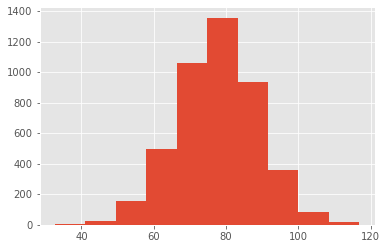

In [20]:
# plotするとパラメータaのヒストグラムは正規分布であることわかる

plt.hist(ms_a)

In [12]:
ms_b = fit.extract("b")["b"]

In [13]:
# 抽出したパラメーから値作る

df_b = pd.DataFrame([])
for i in range(40, 90, 1):
    df_b[i] = ms_a * i + ms_b

In [14]:
df_b

,40,41,42,43,44,45,46,47,48,49,...,80,81,82,83,84,85,86,87,88,89
0,2345.002879,2422.094209,2499.185540,2576.276870,2653.368200,2730.459531,2807.550861,2884.642191,2961.733521,3038.824852,...,5428.656092,5505.747422,5582.838752,5659.930083,5737.021413,5814.112743,5891.204074,5968.295404,6045.386734,6122.478065
1,1210.483741,1318.223410,1425.963079,1533.702748,1641.442418,1749.182087,1856.921756,1964.661425,2072.401094,2180.140763,...,5520.070504,5627.810173,5735.549842,5843.289511,5951.029180,6058.768849,6166.508518,6274.248187,6381.987856,6489.727525
2,2025.247961,2116.530983,2207.814005,2299.097028,2390.380050,2481.663072,2572.946094,2664.229116,2755.512138,2846.795160,...,5676.568846,5767.851868,5859.134890,5950.417912,6041.700934,6132.983956,6224.266978,6315.550000,6406.833022,6498.116045
3,1778.946943,1868.078689,1957.210435,2046.342180,2135.473926,2224.605671,2313.737417,2402.869163,2492.000908,2581.132654,...,5344.216768,5433.348514,5522.480259,5611.612005,5700.743750,5789.875496,5879.007242,5968.138987,6057.270733,6146.402478
4,2686.829769,2761.807728,2836.785688,2911.763648,2986.741607,3061.719567,3136.697526,3211.675486,3286.653446,3361.631405,...,5685.948153,5760.926113,5835.904073,5910.882032,5985.859992,6060.837951,6135.815911,6210.793871,6285.771830,6360.749790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2376.116103,2451.372111,2526.628119,2601.884127,2677.140135,2752.396143,2827.652151,2902.908159,2978.164167,3053.420175,...,5386.356420,5461.612428,5536.868436,5612.124444,5687.380452,5762.636460,5837.892467,5913.148475,5988.404483,6063.660491
4496,2224.871867,2309.444107,2394.016348,2478.588589,2563.160830,2647.733071,2732.305312,2816.877552,2901.449793,2986.022034,...,5607.761500,5692.333741,5776.905981,5861.478222,5946.050463,6030.622704,6115.194945,6199.767186,6284.339426,6368.911667
4497,2947.100836,3014.391403,3081.681971,3148.972538,3216.263105,3283.553673,3350.844240,3418.134808,3485.425375,3552.715942,...,5638.723531,5706.014099,5773.304666,5840.595233,5907.885801,5975.176368,6042.466935,6109.757503,6177.048070,6244.338638
4498,2671.732872,2740.294972,2808.857072,2877.419172,2945.981271,3014.543371,3083.105471,3151.667570,3220.229670,3288.791770,...,5414.216860,5482.778960,5551.341059,5619.903159,5688.465259,5757.027359,5825.589458,5894.151558,5962.713658,6031.275757


In [15]:
# ベイズ信頼区間の上限値下限値を出す

low_y50, high_y50 = mstats.mquantiles(df_b, [0.25,0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025,0.975], axis=0)

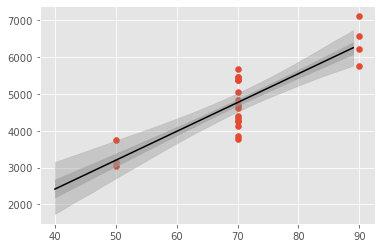

In [16]:
# ベイズ信頼区間を塗りつぶす
# データが多いところは信頼区間が狭い=予測精度が高い
# データが少ないと信頼区間は広くなる

plt.scatter(df["space"],df["value"])
plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")
a = 78.3
b = -713.7
y = a * X_s + b
plt.plot(X_s, y, color ="black")

In [17]:
# 予測区間出すために作成した統計モデルの予測値をサンプリング

Y_p = fit.extract("Y_s")["Y_s"]

In [18]:
# 95%信頼区間準備

low_y, high_y = mstats.mquantiles(Y_p, [0.025,0.975], axis=0)

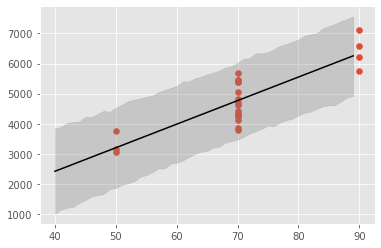

In [19]:
# 予測信頼区間を塗りつぶす
# 95%信頼区間なのでplot点をすっぽり覆うようになってる

plt.scatter(df["space"],df["value"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")
a = 78.3
b = -713.7
y = a * X_s + b
plt.plot(X_s, y, color ="black")